In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [64]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Paths to dataset files
train_images_path = "/content/drive/MyDrive/Brain_images/brain_train_image_final.npy"
train_labels_path = "/content/drive/MyDrive/Brain_images/brain_train_label.npy"
test_images_path = "/content/drive/MyDrive/Brain_images/brain_test_image_final.npy"
test_labels_path = "/content/drive/MyDrive/Brain_images/brain_test_label.npy"

# Load the data
final_X_train = np.load(train_images_path)  # Shape: (1657, 2, 100, 76)
final_y_train = np.load(train_labels_path)  # Shape: (1657,)
final_X_test = np.load(test_images_path)    # Shape: (293, 2, 100, 76)
final_y_test = np.load(test_labels_path)    # Shape: (293,)

# Discard the first channel
final_X_train_modified = final_X_train[:, 1, :, :]  # Shape: (1657, 100, 76)
final_X_test_modified = final_X_test[:, 1, :, :]    # Shape: (293, 100, 76)

# Verify shapes
print(f"Train images shape: {final_X_train_modified.shape}")
print(f"Train labels shape: {final_y_train.shape}")
print(f"Test images shape: {final_X_test_modified.shape}")
print(f"Test labels shape: {final_y_test.shape}")


Train images shape: (1657, 100, 76)
Train labels shape: (1657,)
Test images shape: (293, 100, 76)
Test labels shape: (293,)


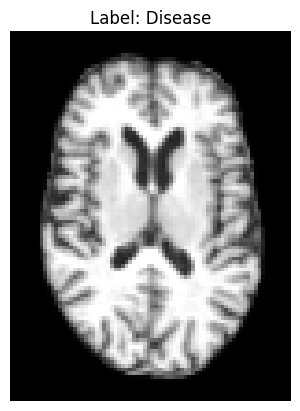

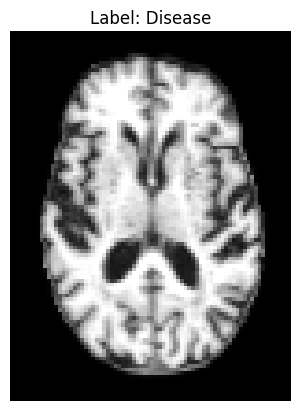

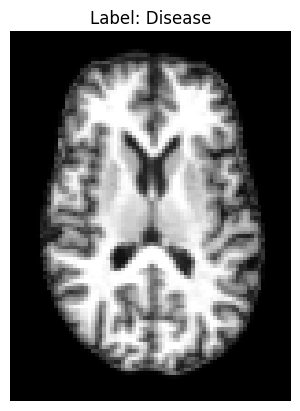

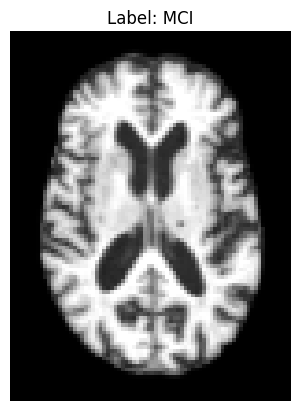

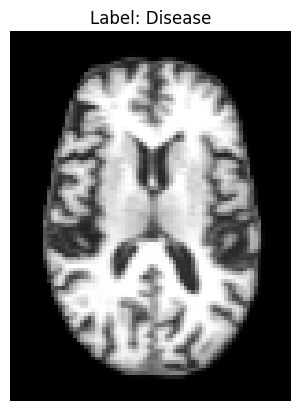

In [65]:
import matplotlib.pyplot as plt

# Define label mapping
label_mapping = {0: "Healthy", 1: "Disease", 2: "MCI"}

# Visualize some examples
for i in range(5):
    plt.imshow(final_X_train_modified[i], cmap='gray')  # Display the second channel
    plt.title(f"Label: {label_mapping[final_y_train[i]]}")
    plt.axis('off')
    plt.show()


In [66]:
from torchvision import transforms

# Define SimCLR augmentations
simclr_augmentation = transforms.Compose([
    transforms.RandomResizedCrop(size=(100, 76), scale=(0.2, 1.0)),  # Random crop and resize
    transforms.RandomHorizontalFlip(p=0.5),                         # Random horizontal flip
    transforms.RandomApply([                                         # Random color jitter
        transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),                              # Random grayscale
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),  # Gaussian blur
    transforms.ToTensor(),                                          # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])                    # Normalize
])


In [67]:
from torchvision.transforms.functional import to_pil_image

class SimCLRDataset(Dataset):
    def __init__(self, images, labels, transform):
        """
        Args:
            images (numpy.ndarray): Input images (H x W).
            labels (numpy.ndarray): Corresponding labels.
            transform (callable): Transformations to apply.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert to PyTorch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)

        # Convert tensor to PIL image for compatibility with torchvision.transforms
        pil_image = to_pil_image(image)

        # Apply augmentations twice to generate two views
        view_1 = self.transform(pil_image)
        view_2 = self.transform(pil_image)

        return view_1, view_2, label


In [68]:
# Create datasets
train_dataset = SimCLRDataset(final_X_train_modified, final_y_train, transform=simclr_augmentation)
test_dataset = SimCLRDataset(final_X_test_modified, final_y_test, transform=simclr_augmentation)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)  # Use fewer workers to avoid warnings
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Test the DataLoader
for view_1, view_2, labels in train_loader:
    print(f"Augmented View 1 Shape: {view_1.shape}")  # Expected: (batch_size, 1, 100, 76)
    print(f"Augmented View 2 Shape: {view_2.shape}")  # Expected: (batch_size, 1, 100, 76)
    print(f"Labels Shape: {labels.shape}")           # Expected: (batch_size,)
    break


Augmented View 1 Shape: torch.Size([128, 1, 100, 76])
Augmented View 2 Shape: torch.Size([128, 1, 100, 76])
Labels Shape: torch.Size([128])


In [69]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

class SimCLR_Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(SimCLR_Encoder, self).__init__()
        # Load ResNet-50 model
        weights = ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
        self.resnet = resnet50(weights=weights)

        # Modify the first convolutional layer to accept 1-channel input
        self.resnet.conv1 = nn.Conv2d(
            in_channels=1,   # Change from 3 to 1 channel
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )

        # Initialize weights for the modified layer
        nn.init.kaiming_normal_(self.resnet.conv1.weight, mode="fan_out", nonlinearity="relu")

        # Remove the classification layer
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])

    def forward(self, x):
        features = self.resnet(x)
        return features.squeeze()  # Remove extra dimensions


In [70]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=2048, hidden_dim=512, output_dim=128):
        super(ProjectionHead, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.mlp(x)


In [71]:
class SimCLR(nn.Module):
    def __init__(self, encoder, projection_head):
        super(SimCLR, self).__init__()
        self.encoder = encoder
        self.projection_head = projection_head

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        return projections


In [72]:
import torch.nn.functional as F

class NTXentLoss(nn.Module):
    def __init__(self, batch_size, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.batch_size = batch_size
        self.criterion = nn.CrossEntropyLoss(reduction="sum")

    def forward(self, z_i, z_j):
        # Normalize the projection vectors
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)

        # Concatenate the two sets of projections
        representations = torch.cat([z_i, z_j], dim=0)

        # Compute similarity matrix
        similarity_matrix = torch.mm(representations, representations.T) / self.temperature

        # Dynamically create labels for positive pairs
        batch_size = z_i.size(0)  # Handle variable batch sizes
        labels = torch.arange(batch_size).to(z_i.device)
        labels = torch.cat([labels, labels], dim=0)

        # Dynamically create mask to remove self-similarities
        mask = torch.eye(labels.size(0), device=labels.device).bool()
        similarity_matrix = similarity_matrix[~mask].view(labels.size(0), -1)

        # Compute loss
        loss = self.criterion(similarity_matrix, labels)
        return loss


In [73]:
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = SimCLR_Encoder(pretrained=True)
projection_head = ProjectionHead(input_dim=2048, hidden_dim=512, output_dim=128)
simclr_model = SimCLR(encoder, projection_head).to(device)

criterion = NTXentLoss(batch_size=128, temperature=0.5).to(device)
optimizer = torch.optim.Adam(simclr_model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    simclr_model.train()
    total_loss = 0

    for view_1, view_2, _ in train_loader:
        view_1, view_2 = view_1.to(device), view_2.to(device)

        # Forward pass
        z_i = simclr_model(view_1)
        z_j = simclr_model(view_2)

        # Compute loss
        loss = criterion(z_i, z_j)
        total_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader)}")


Epoch [1/100], Loss: 1411.8052509014424
Epoch [2/100], Loss: 1411.2943772536057
Epoch [3/100], Loss: 1411.135244516226
Epoch [4/100], Loss: 1410.8387920673076
Epoch [5/100], Loss: 1410.5334942157451
Epoch [6/100], Loss: 1409.9364295372595
Epoch [7/100], Loss: 1408.7681133563701
Epoch [8/100], Loss: 1405.2657376802886
Epoch [9/100], Loss: 1399.5130615234375
Epoch [10/100], Loss: 1395.9712759164663
Epoch [11/100], Loss: 1392.3057955228364
Epoch [12/100], Loss: 1389.342059795673
Epoch [13/100], Loss: 1384.7938044621394
Epoch [14/100], Loss: 1383.578622671274
Epoch [15/100], Loss: 1381.8587270883413
Epoch [16/100], Loss: 1382.9394155649038
Epoch [17/100], Loss: 1379.0542743389424
Epoch [18/100], Loss: 1377.4292931189905
Epoch [19/100], Loss: 1377.2789212740386
Epoch [20/100], Loss: 1379.4710787259614
Epoch [21/100], Loss: 1367.6987961989182
Epoch [22/100], Loss: 1369.665799654447
Epoch [23/100], Loss: 1361.4038837139424
Epoch [24/100], Loss: 1365.3480130709136
Epoch [25/100], Loss: 1365.01

In [74]:
# Freeze the encoder
for param in simclr_model.encoder.parameters():
    param.requires_grad = False

In [75]:
class LinearClassifier(nn.Module):
    def __init__(self, encoder, feature_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.encoder = encoder  # The frozen encoder
        self.fc = nn.Linear(feature_dim, num_classes)  # Linear layer for classification

    def forward(self, x):
        with torch.no_grad():  # Use frozen encoder
            features = self.encoder(x).squeeze()
        return self.fc(features)


In [76]:
num_classes = 3
linear_classifier = LinearClassifier(simclr_model.encoder, feature_dim=2048, num_classes=num_classes).to(device)


In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(linear_classifier.parameters(), lr=1e-3)


In [78]:
# Train the linear classifier
num_epochs = 100
for epoch in range(num_epochs):
    linear_classifier.train()
    total_loss, correct, total = 0, 0, 0

    for images, _, labels in train_loader:  # Only one view is used for classification
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = linear_classifier(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    accuracy = 100.0 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")


Epoch [1/100], Loss: 1.0960, Accuracy: 40.25%
Epoch [2/100], Loss: 1.0745, Accuracy: 41.88%
Epoch [3/100], Loss: 1.0657, Accuracy: 42.37%
Epoch [4/100], Loss: 1.0725, Accuracy: 40.68%
Epoch [5/100], Loss: 1.0640, Accuracy: 42.31%
Epoch [6/100], Loss: 1.0609, Accuracy: 41.58%
Epoch [7/100], Loss: 1.0639, Accuracy: 43.21%
Epoch [8/100], Loss: 1.0531, Accuracy: 43.81%
Epoch [9/100], Loss: 1.0676, Accuracy: 41.76%
Epoch [10/100], Loss: 1.0682, Accuracy: 41.94%
Epoch [11/100], Loss: 1.0548, Accuracy: 43.33%
Epoch [12/100], Loss: 1.0942, Accuracy: 40.43%
Epoch [13/100], Loss: 1.0609, Accuracy: 43.45%
Epoch [14/100], Loss: 1.0604, Accuracy: 42.37%
Epoch [15/100], Loss: 1.0514, Accuracy: 42.55%
Epoch [16/100], Loss: 1.0602, Accuracy: 42.06%
Epoch [17/100], Loss: 1.0708, Accuracy: 43.93%
Epoch [18/100], Loss: 1.0549, Accuracy: 44.24%
Epoch [19/100], Loss: 1.0631, Accuracy: 44.36%
Epoch [20/100], Loss: 1.0543, Accuracy: 42.25%
Epoch [21/100], Loss: 1.0576, Accuracy: 43.09%
Epoch [22/100], Loss: 

In [79]:
# Test the linear classifier
linear_classifier.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, _, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = linear_classifier(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

test_accuracy = 100.0 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 34.47%
